In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import io
import argparse
from collections import namedtuple
import glob


In [2]:
nc_files = glob.glob('trih*.nc')
obs_files = glob.glob('*.obs')
if len(obs_files) == 1:
    nc_file = nc_files[0]
    obs_file = obs_files[0]

In [ ]:
# parser = argparse.ArgumentParser(description='description')
# parser.add_argument('--obs', type=str, default='coarser.obs', help='')
# parser.add_argument('--nc', type=str, default='trih-coarser.nc', help='A')
# args = parser.parse_args()

# argsment = namedtuple('filename', ('obs', 'nc'))
# args = argsment(obs='coarser.obs', nc='trih-coarser.nc')
# args.obs


In [3]:
def extract_station_name(file_path):
    obs_station_name = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            obs = line.split()[0]
            obs_station_name.append(obs.strip())
    return obs_station_name

obs_station_name = extract_station_name(obs_file)
print(obs_station_name)

['AKYABIHO', 'SHORTTISLANDIHO', 'PUSSERRIVERIHO', 'CHITTAGONGIHO']


In [4]:
model_dataset = xr.open_dataset(nc_file)

In [5]:
def Read_tek_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    content_without_header = '\n'.join(content.split('\n')[5:])

    df = pd.read_csv(io.StringIO(content_without_header), 
                    delim_whitespace=True, 
                    names=['Date', 'Time', 'WL'])

    def pad_time(time_str):
        return time_str.zfill(6)

    df['Time'] = df['Time'].astype(str).apply(pad_time)
    df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), format='%Y%m%d %H%M%S')
    df = df.drop(columns=['Date', 'Time'])
    df = df[['DateTime', 'WL']]

    return df

def make_obs_df(obs_station_name):
    obs_df = pd.DataFrame()
    obs_df['Time'] = Read_tek_file(f"{obs_station_name[0]}.tek")['DateTime']
    for name in obs_station_name:
        df = Read_tek_file(f"{name}.tek")['WL']
        obs_df[name] = df

    return obs_df

obs_df = make_obs_df(obs_station_name)

In [6]:
model_df = pd.DataFrame()
model_df['Time'] = model_dataset.time
for i, name in enumerate(obs_station_name):
    model_df[name] = model_dataset['ZWL'].to_numpy()[:, i]

# model_df

In [7]:
def clipped_dataframe(model_df, obs_df):
    start_time = min(model_df['Time'][0], obs_df['Time'][0])
    model_end_date = model_df['Time'][len(model_df['Time'])-1]
    obs_end_date = obs_df['Time'][len(obs_df['Time'])-1]

    if model_end_date > obs_end_date:
        end_time = obs_end_date
        model_df = model_df[(model_df['Time'] >= start_time) & (model_df['Time'] <= end_time)]
    elif model_end_date < obs_end_date:
        end_time = model_end_date
        obs_df = obs_df[(obs_df['Time'] >= start_time) & (obs_df['Time'] <= end_time)]

    return model_df, obs_df

model_df, obs_df = clipped_dataframe(model_df, obs_df)

In [8]:
def interpolate(obs_df, model_df):
    min_interval = min(obs_df['Time'].diff().min(), model_df['Time'].diff().min())

    new_time_index = pd.date_range(start=min(obs_df['Time'].min(), model_df['Time'].min()),
                                end=max(obs_df['Time'].max(), model_df['Time'].max()),
                                freq=min_interval)

    model_interpolated = model_df.set_index('Time').reindex(new_time_index).interpolate()
    obs_interpolated = obs_df.set_index('Time').reindex(new_time_index).interpolate()
    return model_interpolated, obs_interpolated


model_interpolated, obs_interpolated = interpolate(obs_df, model_df)

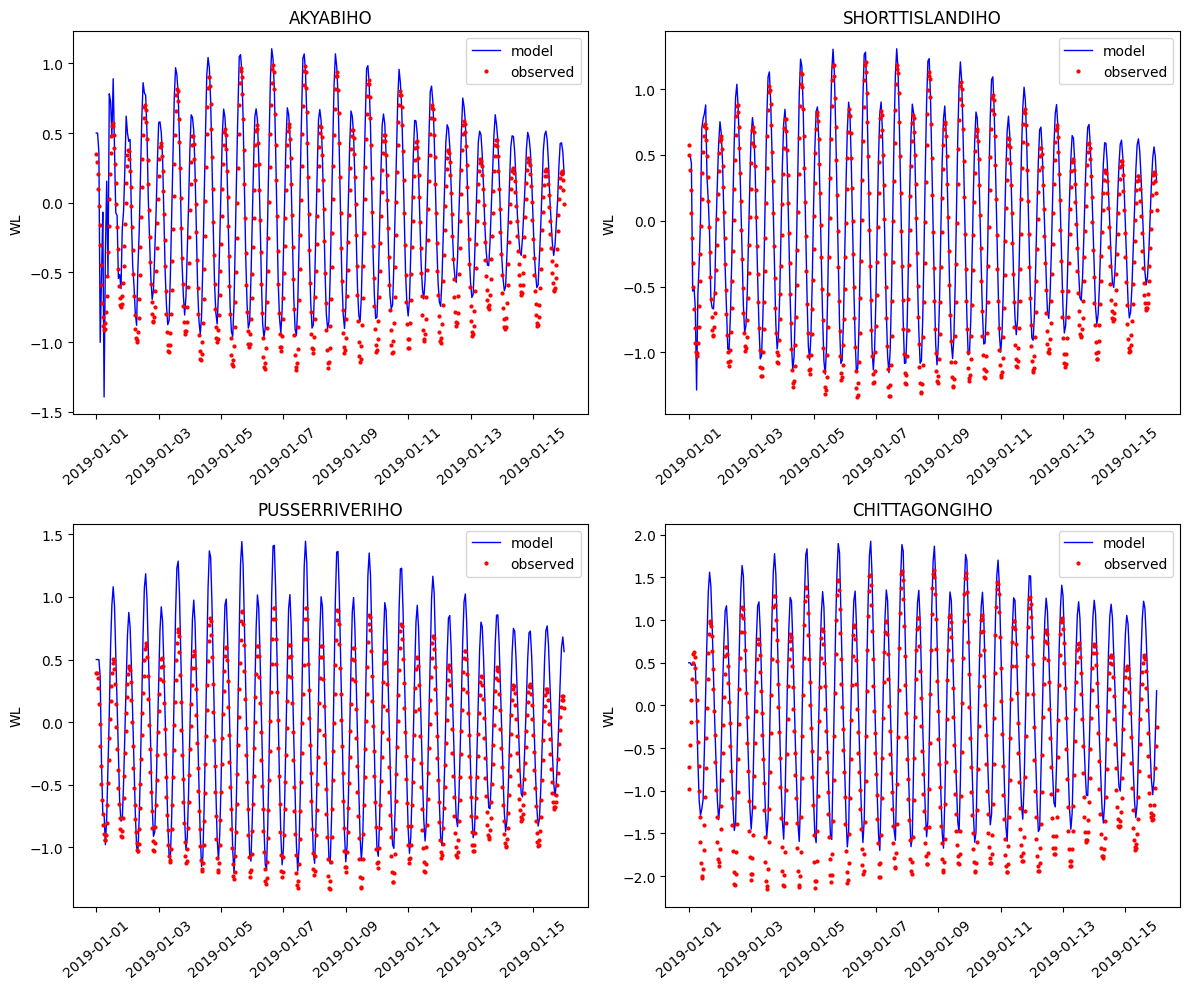

In [16]:
def plot(obs_station_name, model_interpolated, obs_interpolated, ):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.ravel()  # Flatten the 2x2 array to make indexing easier

    for ax in axs:
        ax.clear()  # Clear the axes to prevent multiple legends
        
    for i, name in enumerate(obs_station_name):
        model = model_interpolated[name]
        obs = obs_interpolated[name]

        axs[i].plot(model, label=f"model", color='blue', linewidth=1)
        axs[i].plot(obs, label=f"observed", linestyle='none', marker='o', markersize=2, color="red")
        # axs[i].plot(obs_interpolated[name], label=f"observed - {name}", linestyle='none', marker='o', markersize=2)

        axs[i].set_title(name)
        # axs[i].set_xlabel('X-axis')
        axs[i].set_ylabel('WL')
        axs[i].tick_params(axis='x', rotation=40)
        axs[i].legend()

    plt.tight_layout()
    plt.show()


plot(obs_station_name, model_interpolated, obs_interpolated)